# Introduction

This notebook demonstratess use of **Batch Normalization** in a simple **ConvNet** applied to [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

**Note:** Original [batch norm paper](https://arxiv.org/abs/1502.03167) explains it's effectivness with "internal covariate shift". But [this recent paper](https://arxiv.org/abs/1805.11604) shows it's actually due to batch norm making "optimization landscape significantly smoother". Both might be worth to read.

**Contents**

* [CIFAR-10 Dataset](#CIFAR-10-Dataset) - load and preprocess dataset
* [BN Before Activation](#BN-Before-Activation) - as per original [batch norm paper](https://arxiv.org/abs/1502.03167)
* [BN After Activation](#BN-After-Activation) - sometimes give slightly better results

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage


In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

# CIFAR-10 Dataset

Load dataset and show example images

In [3]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()
class2txt = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Show example images

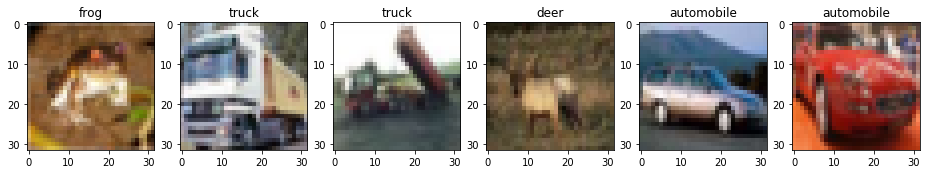

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(class2txt[y_train_raw[i, 0]])
    axes[i].imshow(x_train_raw[i])

Normalize features

In [5]:
x_train = (x_train_raw - x_train_raw.mean()) / x_train_raw.std()
x_test = (x_test_raw - x_train_raw.mean()) / x_train_raw.std()
print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

x_train.shape (50000, 32, 32, 3)
x_test.shape (10000, 32, 32, 3)


One-hot encode labels

In [6]:
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=10)
print('y_train.shape', y_train.shape)
print(y_train[:3])

y_train.shape (50000, 10)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# BN Before Activation

Create model

* apply Conv2D <u>without</u> activation or bias
* apply batch normalization
* apply activation
* apply max-pool

There is a bit of confusion going on with BatchNormalization **axis=-1** parameter. As per original batch norm paper, in convolutional layers we want to apply batch norm per channel (as opposed to per-feature in dense layers). Batch norm creates 4x params for each distinct feature it normalizes, so a good sanity check is to ensure that **Param # equals to 4x nb filters**.

In [7]:
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout

model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation=None, use_bias=False))
model.add(BatchNormalization())   # leave default axis=-1 in all BN layers
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=None, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=None, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        432       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
__________

Train model

In [8]:
hist = model.fit(x=x_train, y=y_train, batch_size=250, epochs=10, validation_data=[x_test, y_test], verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 5s - loss: 1.6958 - acc: 0.4322 - val_loss: 1.5946 - val_acc: 0.4415
Epoch 2/10
 - 3s - loss: 1.2068 - acc: 0.5734 - val_loss: 1.0327 - val_acc: 0.6338
Epoch 3/10
 - 3s - loss: 1.0316 - acc: 0.6362 - val_loss: 0.9225 - val_acc: 0.6782
Epoch 4/10
 - 3s - loss: 0.9267 - acc: 0.6723 - val_loss: 0.8463 - val_acc: 0.7028
Epoch 5/10
 - 3s - loss: 0.8477 - acc: 0.7029 - val_loss: 0.7955 - val_acc: 0.7211
Epoch 6/10
 - 3s - loss: 0.8002 - acc: 0.7199 - val_loss: 0.7940 - val_acc: 0.7192
Epoch 7/10
 - 3s - loss: 0.7457 - acc: 0.7363 - val_loss: 0.7269 - val_acc: 0.7410
Epoch 8/10
 - 3s - loss: 0.7109 - acc: 0.7502 - val_loss: 0.6987 - val_acc: 0.7558
Epoch 9/10
 - 3s - loss: 0.6815 - acc: 0.7612 - val_loss: 0.7015 - val_acc: 0.7530
Epoch 10/10
 - 3s - loss: 0.6490 - acc: 0.7704 - val_loss: 0.6899 - val_acc: 0.7590


Final results

In [9]:
loss, acc = model.evaluate(x_train, y_train, batch_size=250, verbose=0)
print(f'Accuracy on train set: {acc:.3f}')
loss, acc = model.evaluate(x_test, y_test, batch_size=250, verbose=0)
print(f'Accuracy on test set:  {acc:.3f}')

Accuracy on train set: 0.836
Accuracy on test set:  0.759


# BN After Activation

Create model

* apply Conv2D with activation but <u>without</u> bias
* apply batch normalization
* apply max-pool

In [10]:
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='elu', use_bias=False))
#model.add(Activation('elu'))
model.add(BatchNormalization())   # leave default axis=-1 in all BN layers
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='elu', use_bias=False))
#model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='elu', use_bias=False))
#model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 16)        432       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        4608      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18432     
__________

In [11]:
hist = model.fit(x=x_train, y=y_train, batch_size=250, epochs=10, validation_data=[x_test, y_test], verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 1.6445 - acc: 0.4548 - val_loss: 1.3127 - val_acc: 0.5355
Epoch 2/10
 - 3s - loss: 1.1684 - acc: 0.5909 - val_loss: 0.9892 - val_acc: 0.6480
Epoch 3/10
 - 3s - loss: 0.9867 - acc: 0.6526 - val_loss: 0.8886 - val_acc: 0.6874
Epoch 4/10
 - 3s - loss: 0.8836 - acc: 0.6876 - val_loss: 0.8381 - val_acc: 0.7117
Epoch 5/10
 - 3s - loss: 0.8051 - acc: 0.7147 - val_loss: 0.7951 - val_acc: 0.7197
Epoch 6/10
 - 3s - loss: 0.7546 - acc: 0.7344 - val_loss: 0.7497 - val_acc: 0.7329
Epoch 7/10
 - 3s - loss: 0.7003 - acc: 0.7528 - val_loss: 0.7559 - val_acc: 0.7369
Epoch 8/10
 - 4s - loss: 0.6519 - acc: 0.7679 - val_loss: 0.7065 - val_acc: 0.7536
Epoch 9/10
 - 3s - loss: 0.6203 - acc: 0.7804 - val_loss: 0.6992 - val_acc: 0.7536
Epoch 10/10
 - 3s - loss: 0.5876 - acc: 0.7916 - val_loss: 0.6985 - val_acc: 0.7583


Final results

In [12]:
loss, acc = model.evaluate(x_train, y_train, batch_size=250, verbose=0)
print(f'Accuracy on train set: {acc:.3f}')
loss, acc = model.evaluate(x_test, y_test, batch_size=250, verbose=0)
print(f'Accuracy on test set:  {acc:.3f}')

Accuracy on train set: 0.869
Accuracy on test set:  0.758
